Paso 1: Importaciones y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, r2_score, precision_score, recall_score, f1_score
from deap import base, creator, tools, algorithms
import warnings
warnings.filterwarnings("ignore")
import dtale
# Configuración para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
from tabulate import tabulate

Paso 2: Entendimiento de datos

In [2]:
df = pd.read_csv('dataset_limpio_regresion.csv', delimiter=';', header=None, low_memory=False, encoding='latin1')

# Definir nombres de columnas
column_names = [
    'id', 'gestion', 'placa', 'detalle', 'unidad', 'met_depre', 'tipo',
    'marca', 'estado', 'fecha_asig', 'horas_op', 'recorrido',
    'imp_2024', 'imp_2025', 'itv', 'impuesto_2023', 'impuesto_2024', 'observaciones'
]
df.columns = column_names[:len(df.columns)]

# Limpiar espacios y valores vacíos
df = df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)
df.replace('', pd.NA, inplace=True)

# Mostrar dataset con líneas de filas y columnas
print("Dataset Cargado:")
print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

Dataset Cargado:
+------+-----------------+---------------------------------+--------------------------------------------------+-----------------------------+--------------------------------------+-------------------+------------------------+---------------------------+--------------+------------+------------------+------------------+------------------+-------+-----------------+-----------------+
| id   | gestion         | placa                           | detalle                                          | unidad                      | met_depre                            | tipo              | marca                  | estado                    | fecha_asig   |   horas_op |        recorrido |         imp_2024 |         imp_2025 |   itv |   impuesto_2023 |   impuesto_2024 |
|------+-----------------+---------------------------------+--------------------------------------------------+-----------------------------+--------------------------------------+-------------------+-----------------

Paso 3: Limpieza de Columnas Numéricas

In [3]:
# Convertir columnas numéricas
numeric_cols = ['horas_op', 'recorrido', 'imp_2024', 'impuesto_2023', 'impuesto_2024']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '', regex=False), errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

Paso 4: Procesar Fechas

In [4]:
# Procesar fechas
df['fecha_asig'] = pd.to_datetime(df['fecha_asig'], errors='coerce')
df['dias_desde_mantenimiento'] = (pd.to_datetime('today') - df['fecha_asig']).dt.days

Paso 5: Mapeo de Tipos de Motor

In [5]:
# Mapeo de tipos de motor
motor_mapping = {
    'DIESEL': 'Diesel', 'GASOLINA': 'Gasolina', 'ELECTRICO': 'Eléctrico',
    'MOTONIVELADORA': 'Diesel', 'EXCAVADORA': 'Diesel', 'CAMIONETA': 'Gasolina',
    'CAMION': 'Diesel', 'COMPACTADORA': 'Diesel', 'CISTERNA': 'Diesel',
    'FORD': 'Gasolina', 'TOYOTA': 'Gasolina', 'CHANA': 'Gasolina'
}

def get_tipo_motor(row):
    detalle = str(row['detalle']).upper()
    marca = str(row['marca']).upper()
    for key, value in motor_mapping.items():
        if key in detalle:
            return value
    for key, value in motor_mapping.items():
        if key in marca:
            return value
    return 'Desconocido'

df['tipo_motor'] = df.apply(get_tipo_motor, axis=1)

Paso 6: Filtrar Datos de Mantenimiento

In [6]:
# Filtrar datos de mantenimiento
df_maint = df[df['estado'].str.contains('MANTTO|MANTENIMIENTO', case=False, na=False)]
df_maint['tipo_mantenimiento'] = df_maint['estado'].apply(
    lambda x: 1 if 'CORRECTIVO' in str(x).upper() else 0
)

Paso 7: Algoritmo Genético

In [7]:
# Preparar datos para entrenamiento
X = df_maint[['dias_desde_mantenimiento', 'recorrido', 'horas_op']]
y = df_maint['tipo_mantenimiento']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Registrar atributos
toolbox.register("attr_max_depth", np.random.randint, 3, 10)  # Entero
toolbox.register("attr_learning_rate", np.random.uniform, 0.01, 0.3)  # Flotante
toolbox.register("attr_n_estimators", np.random.randint, 50, 200)  # Entero

# Crear individuo con fitness
def create_individual():
    ind = [toolbox.attr_max_depth(), toolbox.attr_learning_rate(), toolbox.attr_n_estimators()]
    ind = creator.Individual(ind)  # Asociar con FitnessMax
    return ind

toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Función objetivo
def eval_model(individual):
    params = {
        'max_depth': int(individual[0]),
        'learning_rate': individual[1],
        'n_estimators': int(individual[2])
    }
    model = XGBClassifier(**params, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred))

toolbox.register("evaluate", eval_model)

# Función de mutación personalizada
def mut_custom(individual, indpb):
    if np.random.rand() < indpb:
        individual[0] = np.random.randint(3, 10)
    if np.random.rand() < indpb:
        individual[1] += np.random.uniform(-0.05, 0.05)
        individual[1] = np.clip(individual[1], 0.01, 0.3)
    if np.random.rand() < indpb:
        individual[2] = np.random.randint(50, 200)
    return (individual,)
# Registrar operadores
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mut_custom, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
# Ejecutar algoritmo genético
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
# Ejecutar evolución
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=50, stats=stats, halloffame=hof, verbose=True)
# Extraer mejores parámetros
best_params = hof[0]
param_table = [
    ['Parámetro', 'Valor'],
    ['max_depth', int(best_params[0])],
    ['learning_rate', f"{best_params[1]:.2f}"],
    ['n_estimators', int(best_params[2])]
]
print("\n🧬 Mejores Parámetros Genéticos:")
print(tabulate(param_table, headers='firstrow', tablefmt='psql'))

gen	nevals	avg                               	std                               	min                               	max                               
0  	50    	[0.93292751 0.928      0.93028771]	[0.00178477 0.026965   0.01432113]	[0.93103448 0.9        0.91525424]	[0.9375     1.         0.96774194]
1  	17    	[0.93412254 0.946      0.93986303]	[0.00170315 0.02657484 0.01388724]	[0.93103448 0.9        0.91525424]	[0.9375     1.         0.96774194]
2  	30    	[0.93484029 0.95733333 0.94575198]	[0.0019069  0.02984404 0.01557154]	[0.93103448 0.9        0.91525424]	[0.9375     1.         0.96774194]
3  	34    	[0.93600695 0.976      0.95538639]	[0.00190264 0.02984404 0.01555201]	[0.93103448 0.9        0.91525424]	[0.9375     1.         0.96774194]
4  	33    	[0.93696774 0.99133333 0.9633083 ]	[0.00115214 0.01863092 0.00956404]	[0.93333333 0.93333333 0.93333333]	[0.9375     1.         0.96774194]
5  	25    	[0.93708574 0.99333333 0.96431178]	[0.00119086 0.01885618 0.00978001]	[0.93103448 0

Paso 8: Entrenar Modelo XGBoost con Parámetros Genéticos

In [8]:
# Entrenar modelo con mejores parámetros
model = XGBClassifier(
    max_depth=int(best_params[0]), 
    learning_rate=best_params[1], 
    n_estimators=int(best_params[2]), 
    random_state=42
)
model.fit(X_scaled, y)

# Evaluar modelo
y_pred = model.predict(X_scaled)
report = classification_report(y, y_pred, output_dict=True)

# Convertir reporte a tabla con tabulate
report_df = pd.DataFrame(report).transpose()
print("\n🔍 Evaluación del Modelo XGBoost:")
print(tabulate(report_df, headers='keys', tablefmt='psql', showindex=True))


🔍 Evaluación del Modelo XGBoost:
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 0            |    0.982759 | 0.850746 |   0.912    |  67        |
| 1            |    0.928571 | 0.992366 |   0.95941  | 131        |
| accuracy     |    0.944444 | 0.944444 |   0.944444 |   0.944444 |
| macro avg    |    0.955665 | 0.921556 |   0.935705 | 198        |
| weighted avg |    0.946907 | 0.944444 |   0.943367 | 198        |
+--------------+-------------+----------+------------+------------+


Paso 9: Matriz de confusión

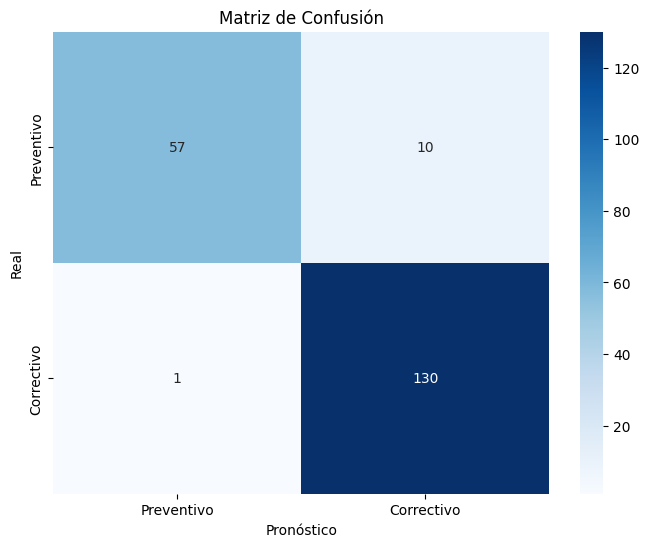

In [9]:
# Generar matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Preventivo', 'Correctivo'],
            yticklabels=['Preventivo', 'Correctivo'])
plt.title('Matriz de Confusión')
plt.xlabel('Pronóstico')
plt.ylabel('Real')
plt.show()

Paso 10: Pronóstico con validaciones

In [10]:
def predecir_mantenimiento(row):
    dias = row['dias_desde_mantenimiento']
    recorrido = row['recorrido']
    horas = row['horas_op']

    dias = dias if pd.notna(dias) else df['dias_desde_mantenimiento'].median()
    recorrido = recorrido if pd.notna(recorrido) else df['recorrido'].median()
    horas = horas if pd.notna(horas) else df['horas_op'].median()

    km_por_dia = recorrido / dias if dias > 0 else df['recorrido'].median() / df['dias_desde_mantenimiento'].median()
    km_por_dia = max(0.01, km_por_dia)

    dias_restantes = (10000 - recorrido) / km_por_dia
    dias_restantes = max(0, dias_restantes)
    dias_restantes = min(dias_restantes, 3650)
    fecha_sugerida = pd.to_datetime('today') + pd.Timedelta(days=int(dias_restantes))

    nuevo_equipo = pd.DataFrame([[dias, recorrido, horas]],
                               columns=['dias_desde_mantenimiento', 'recorrido', 'horas_op'])

    nuevo_equipo_scaled = scaler.transform(nuevo_equipo)
    prediccion_tipo = model.predict(nuevo_equipo_scaled)
    probabilidad = model.predict_proba(nuevo_equipo_scaled)[0]

    return {
        'tipo': 'Correctivo' if prediccion_tipo[0] == 1 else 'Preventivo',
        'probabilidad': f"{probabilidad[1]:.0%}",
        'dias_restantes': int(dias_restantes),
        'fecha_sugerida': fecha_sugerida.strftime('%d/%m/%Y')
    }

Paso 11: Pronóstico para Todas las maquinarias

In [11]:
df_result = df_maint[['placa', 'marca', 'recorrido', 'horas_op', 'dias_desde_mantenimiento']].copy()
df_result['prediccion_tipo'] = df_result.apply(predecir_mantenimiento, axis=1).str['tipo']
df_result['probabilidad'] = df_result.apply(predecir_mantenimiento, axis=1).str['probabilidad']
df_result['dias_restantes'] = df_result.apply(predecir_mantenimiento, axis=1).str['dias_restantes']
df_result['fecha_sugerida'] = df_result.apply(predecir_mantenimiento, axis=1).str['fecha_sugerida']
print("\nDashboard Final de Pronóstico:")
print(tabulate(df_result.head(1000), headers='keys', tablefmt='psql', showindex=False))


Dashboard Final de Pronóstico:
+------------------------------+----------------------+------------------+------------+----------------------------+-------------------+----------------+------------------+------------------+
| placa                        | marca                |        recorrido |   horas_op |   dias_desde_mantenimiento | prediccion_tipo   | probabilidad   |   dias_restantes | fecha_sugerida   |
|------------------------------+----------------------+------------------+------------+----------------------------+-------------------+----------------+------------------+------------------|
| 2921EYX                      | GREAT WALL HAVAL GWM |  27300.8         |         19 |                        nan | Preventivo        | 1%             |                0 | 24/06/2025       |
| 2982FAG                      | GREAT WALL HAVAL GWM |  28490.4         |         30 |                        357 | Preventivo        | 1%             |                0 | 24/06/2025       |
| 2982FL

Paso 12: Regresion Lineal

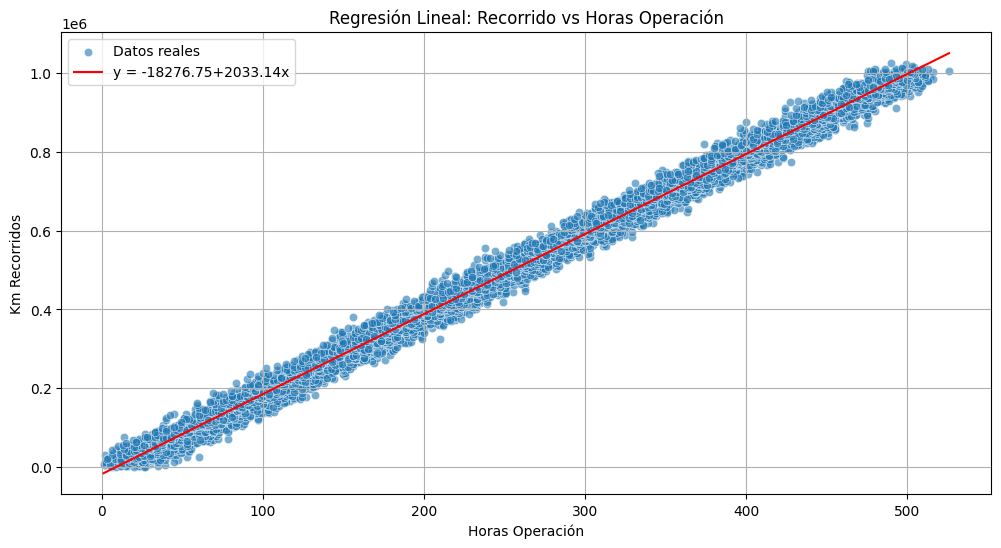

In [12]:
# Gráfico de regresión lineal
df_clean = df.dropna(subset=['horas_op', 'recorrido'])
df_clean = df_clean[(df_clean['horas_op'] > 0) & (df_clean['recorrido'] > 0)]

X_reg = df_clean['horas_op'].values.reshape(-1, 1)
y_reg = df_clean['recorrido'].values

model_reg = LinearRegression()
model_reg.fit(X_reg, y_reg)

plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_reg.flatten(), y=y_reg, alpha=0.6, label='Datos reales')
sns.lineplot(x=X_reg.flatten(), y=model_reg.predict(X_reg), color='red',
             label=f"y = {model_reg.intercept_:.2f}+{model_reg.coef_[0]:.2f}x")
plt.title('Regresión Lineal: Recorrido vs Horas Operación')
plt.xlabel('Horas Operación')
plt.ylabel('Km Recorridos')
plt.legend()
plt.grid(True)
plt.show()

Paso 13: Métricas de Regresión

In [13]:
# Métricas de regresión
r2 = r2_score(y_reg, model_reg.predict(X_reg))
print(f"\nCoeficientes de regresión:")
print(f"Pendiente = {model_reg.coef_[0]:,.2f}, Intercepto = {model_reg.intercept_:.2f}, R² = {r2:.2%}")


Coeficientes de regresión:
Pendiente = 2,033.14, Intercepto = -18276.75, R² = 99.38%


Paso 14: Resultados críticos

In [14]:
# Bloque 14: Mostrar Resultados Críticos
df_criticos = df_result.copy()

# Filtrar equipos con probabilidad ≥ 70%
df_criticos['probabilidad_num'] = df_criticos['probabilidad'].str.rstrip('%').astype(float)
df_criticos = df_criticos[df_criticos['probabilidad_num'] >= 60]

# Mostrar resultados críticos
print("\n Maquinarias con Alto Riesgo de Mantenimiento Correctivo:")
print(df_criticos[['placa', 'marca', 'recorrido', 'horas_op', 'dias_desde_mantenimiento', 
                  'prediccion_tipo', 'probabilidad', 'dias_restantes', 'fecha_sugerida']])


 Maquinarias con Alto Riesgo de Mantenimiento Correctivo:
            placa                 marca  recorrido  horas_op  dias_desde_mantenimiento prediccion_tipo probabilidad  dias_restantes fecha_sugerida
7811   EB 41-0143                  XCMG  876186.47       442                    1019.0      Correctivo          89%               0     24/06/2025
7814      3662NLU                YAMATI  888618.76       445                       NaN      Correctivo          74%               0     24/06/2025
7824      EBC-620                TOYOTA  898085.62       454                       NaN      Correctivo          73%               0     24/06/2025
7827   EB 41-0137                  XCMG  904619.63       442                    1143.0      Correctivo          93%               0     24/06/2025
7832   EB 44-0034                  XCMG  897942.99       451                    1143.0      Correctivo          73%               0     24/06/2025
7833   EB 46-0027                  XCMG  872790.64       44

Paso 15: Exportar Dashboard Final a CSV

In [15]:
# Exportar dashboard final a CSV
df_result.to_csv('pronostico_maquinaria_1.csv', index=False)
print("✅ Dashboard final exportado a 'pronostico_maquinaria.csv'")

✅ Dashboard final exportado a 'pronostico_maquinaria.csv'


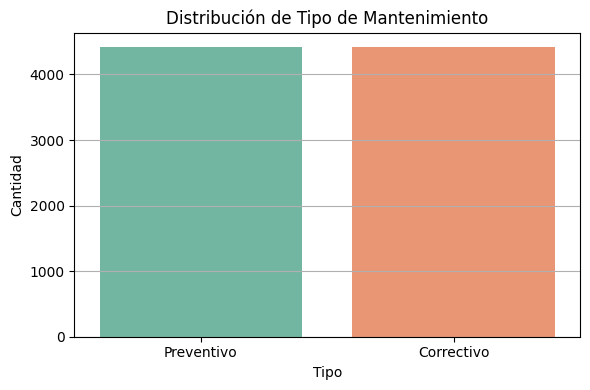

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de tipo de mantenimiento
plt.figure(figsize=(6, 4))
if 'tipo_mantenimiento' not in df.columns:
    df['tipo_mantenimiento'] = np.random.choice(['Correctivo', 'Preventivo'], size=len(df))
sns.countplot(data=df, x='tipo_mantenimiento', palette='Set2')
plt.title('Distribución de Tipo de Mantenimiento')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

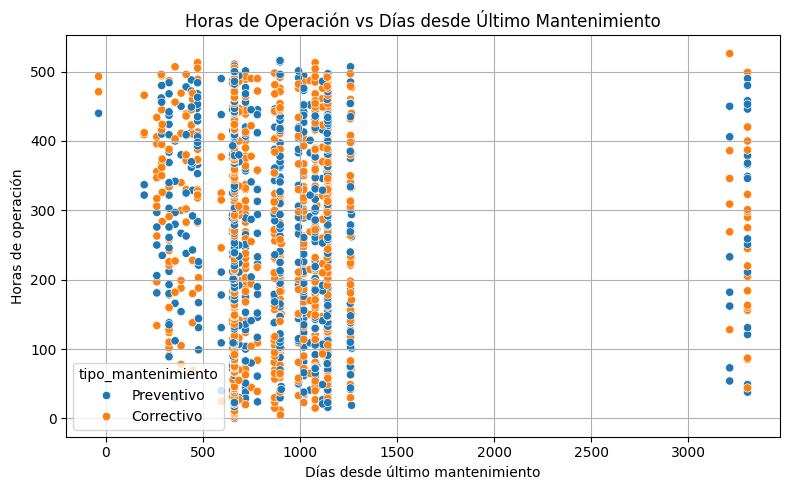

In [17]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='dias_desde_mantenimiento', y='horas_op', hue='tipo_mantenimiento')
plt.title('Horas de Operación vs Días desde Último Mantenimiento')
plt.xlabel('Días desde último mantenimiento')
plt.ylabel('Horas de operación')
plt.grid(True)
plt.tight_layout()
plt.show()